# Birth dates

### information about the associated study

Levy, B. R., Chung, P. H., & Slade, M. D. (2011). [Influence of Valentine’s Day and Halloween on birth timing](https://andrewgelman.com/wp-content/uploads/2012/02/halloween.pdf). Social Science & Medicine, 73(8), 1246-1248.

![alt](https://andrewgelman.com/wp-content/uploads/2012/02/Screen-shot-2012-02-14-at-8.06.17-AM.png)

## imports

In [20]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from ipywidgets import interact

import matplotlib.pyplot as plt
import seaborn as sns

#### set defaults

In [2]:
sns.set_style('ticks')
sns.set_context('poster')

## load data

In [3]:
df = pd.read_csv('../data/birthdates-1968-1988.csv')

In [4]:
df.tail()

,year,month,day,births,day_of_year,day_of_week
7300,1988,12,27,11528,362,2
7301,1988,12,28,11847,363,3
7302,1988,12,29,11704,364,4
7303,1988,12,30,11837,365,5
7304,1988,12,31,9133,366,6


## clean data

In [5]:
# find all entires of feb 29th
is_29feb = (df.loc[:, 'month'] == 2) & (df.loc[:, 'day'] == 29)

# find all other entries
idx = (is_29feb == False)

# only include entries that are not feb 29
clean_df = df[idx]

In [6]:
clean_df.shape

(7300, 6)

## explore variables

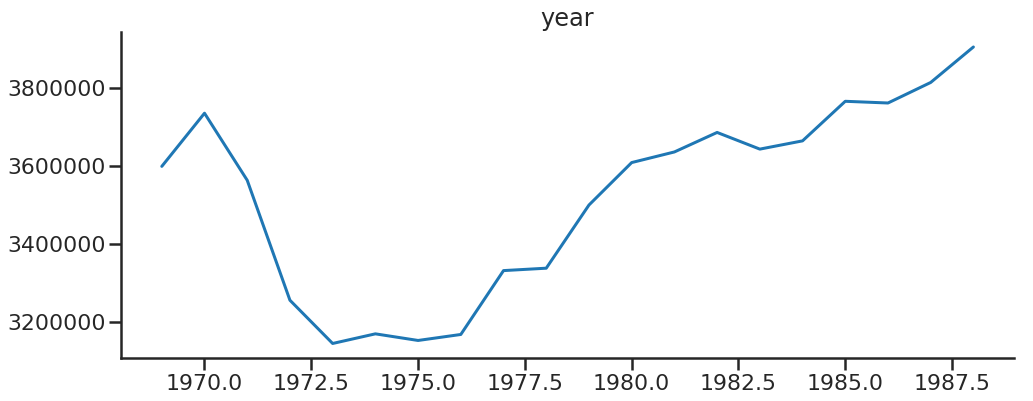

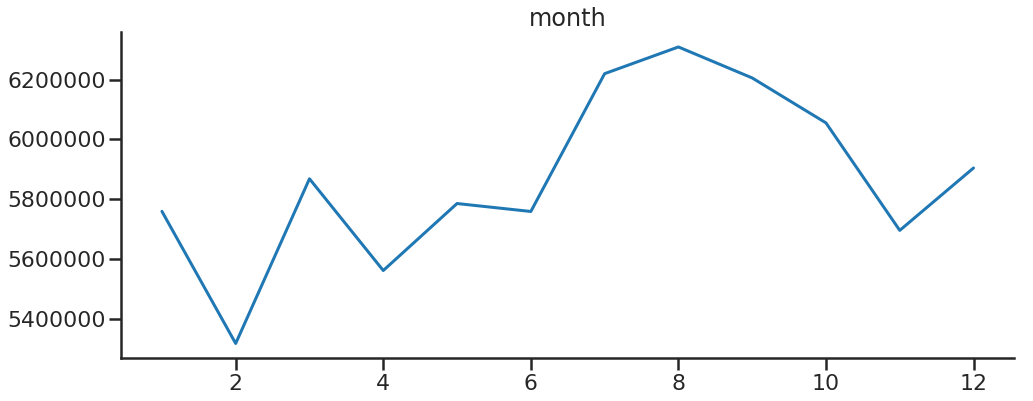

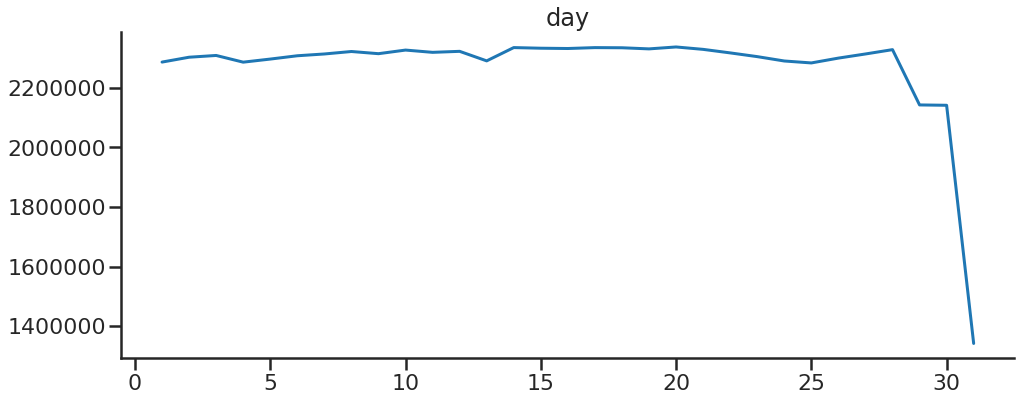

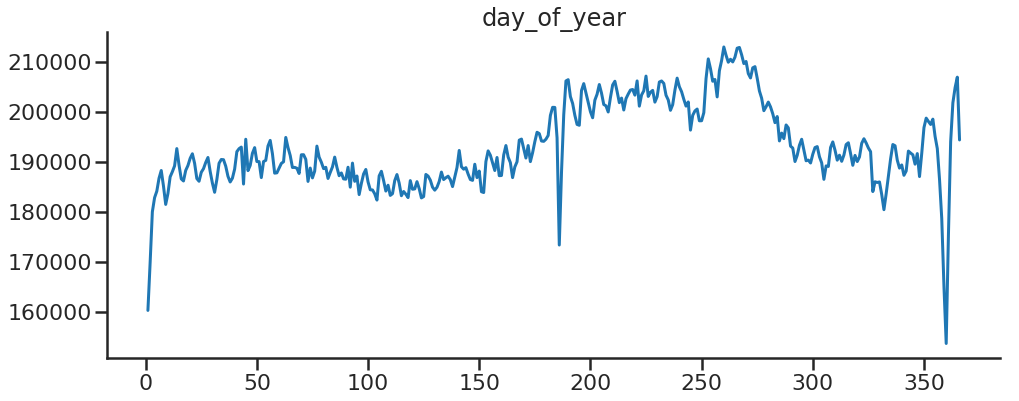

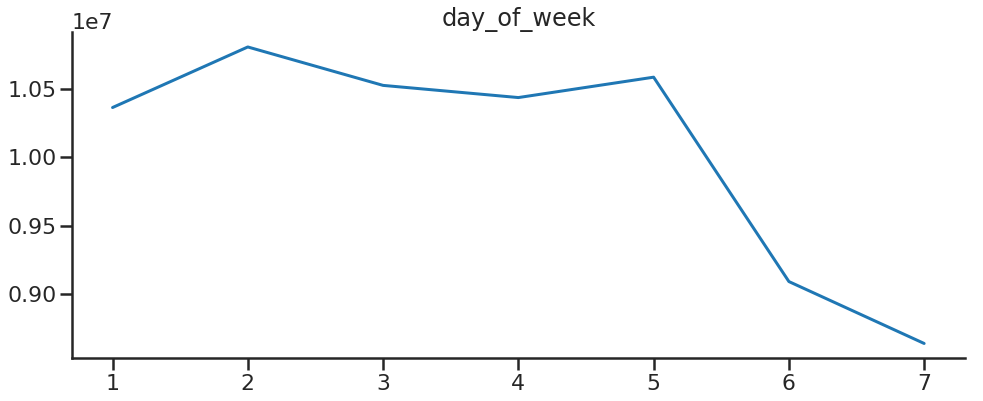

In [7]:
# for every variable except the dependent variable
for col in clean_df.columns.drop('births'):

    # group the sum of births by that variable
    sum_df = clean_df.groupby(col).sum().loc[:, ['births']]

    # show the results
    plt.figure(figsize=(16, 6))
    plt.plot(sum_df)
    plt.title(col)
    sns.despine()
    plt.show()

### distribution of weekdays

In [8]:
def plot_day(day): 
    
    # find entries with specified day of year
    is_day = clean_df.loc[:,'day_of_year']==day
    # filter the table accordingly
    day_df = clean_df[is_day]
    
    # show distribution of weekdays
    sns.distplot(day_df.loc[:, 'day_of_week'], bins=7, kde=False)
    plt.xticks(range(1,8,1),['M','T','W','T','F','S','S'])
    plt.title(day)
    sns.despine(trim=True)
    plt.show()

In [9]:
i = interact(plot_day,day=(1,365))

interactive(children=(IntSlider(value=183, description='day', max=365, min=1), Output()), _dom_classes=('widge…

## transform data

Summarize of 365 days

In [10]:
sum_df = clean_df.groupby('day_of_year').sum().loc[:, ['births']]
sum_df.index = pd.date_range('2001-01-01', periods=365, freq='D')

In [11]:
sum_df.tail()

,births
2001-12-27,194006
2001-12-28,201768
2001-12-29,204806
2001-12-30,206894
2001-12-31,194368


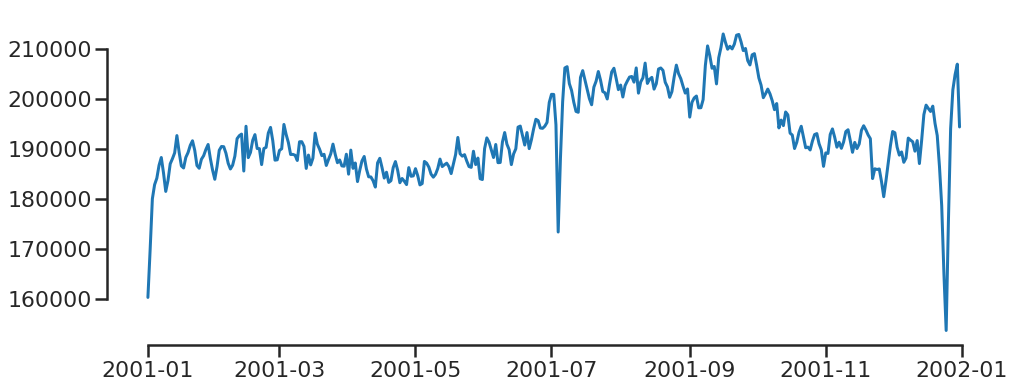

In [12]:
plt.figure(figsize=(16,6))
plt.plot(sum_df)
sns.despine(trim=True)
plt.show()

## model the data

In [13]:
result_decompose = sm.tsa.seasonal_decompose(sum_df,extrapolate_trend=1)

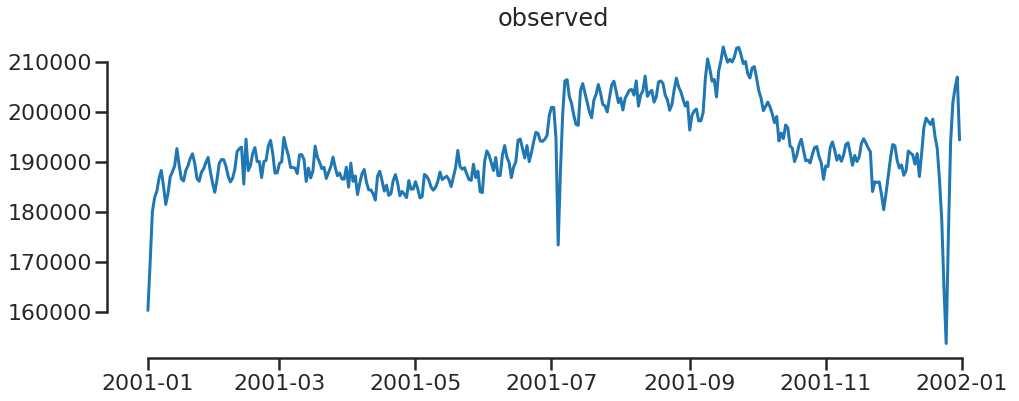

In [14]:
plt.figure(figsize=(16,6))
plt.plot(result_decompose.observed)
plt.title('observed')
sns.despine(trim=True)
plt.show()

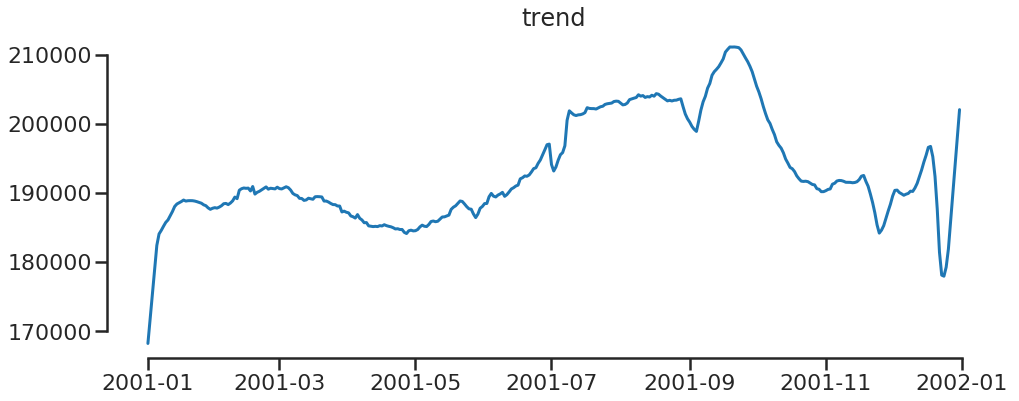

In [15]:
plt.figure(figsize=(16,6))
plt.plot(result_decompose.trend)
plt.title('trend')
sns.despine(trim=True)
plt.show()

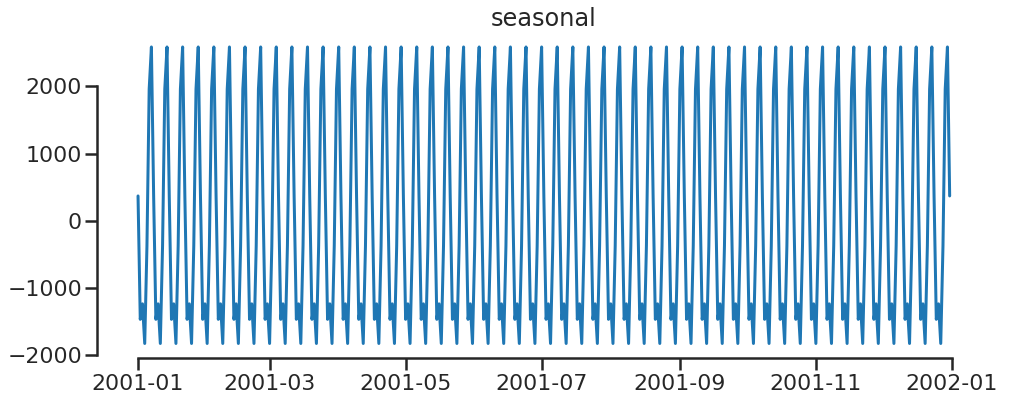

In [16]:
plt.figure(figsize=(16,6))
plt.plot(result_decompose.seasonal)
plt.title('seasonal')
sns.despine(trim=True)
plt.show()

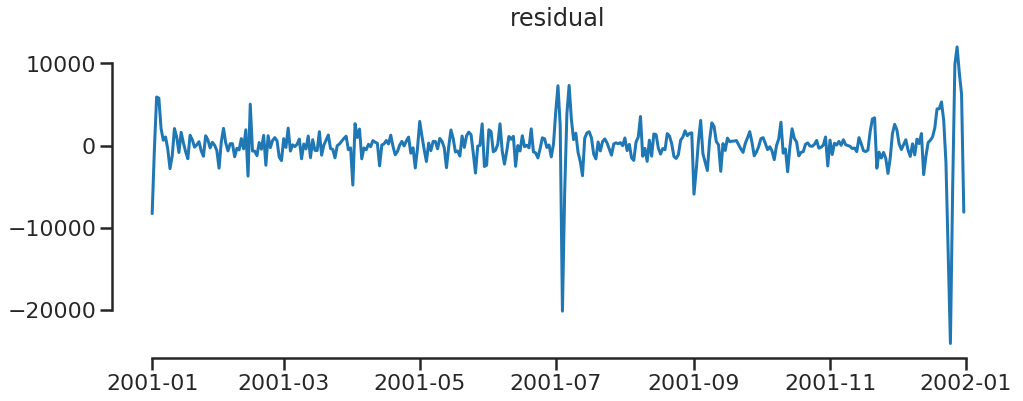

In [17]:
plt.figure(figsize=(16,6))
plt.plot(result_decompose.resid)
plt.title('residual')
sns.despine(trim=True)
plt.show()

## focus on valentine's day

### raw data and predictions

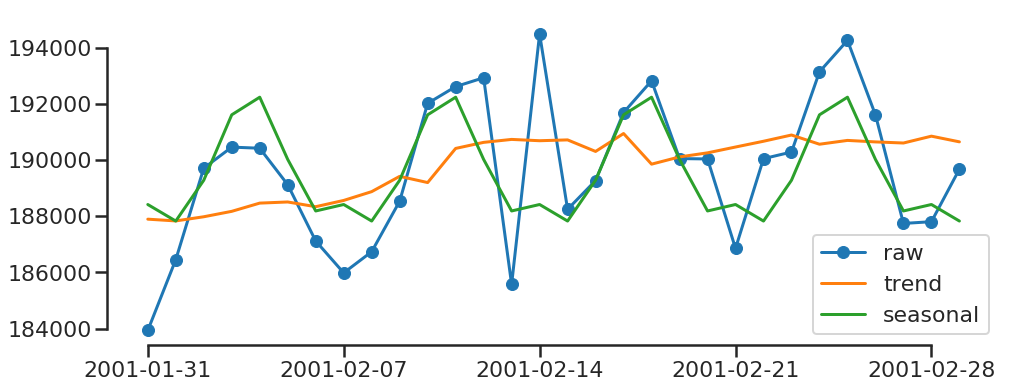

In [18]:
plt.figure(figsize=(16, 6))

plt.plot(
    result_decompose.observed.iloc[30:60], 
    '-o', 
    label='raw')

plt.plot(
    result_decompose.trend.iloc[30:60], 
    '-', 
    label='trend')

plt.plot(
    result_decompose.seasonal.iloc[30:60] +
    result_decompose.observed.iloc[30:60].mean(),
    '-',
    label='seasonal')

plt.legend(loc='best')

sns.despine(trim=True)
plt.show()

### residuals, where the models cannot explain the data

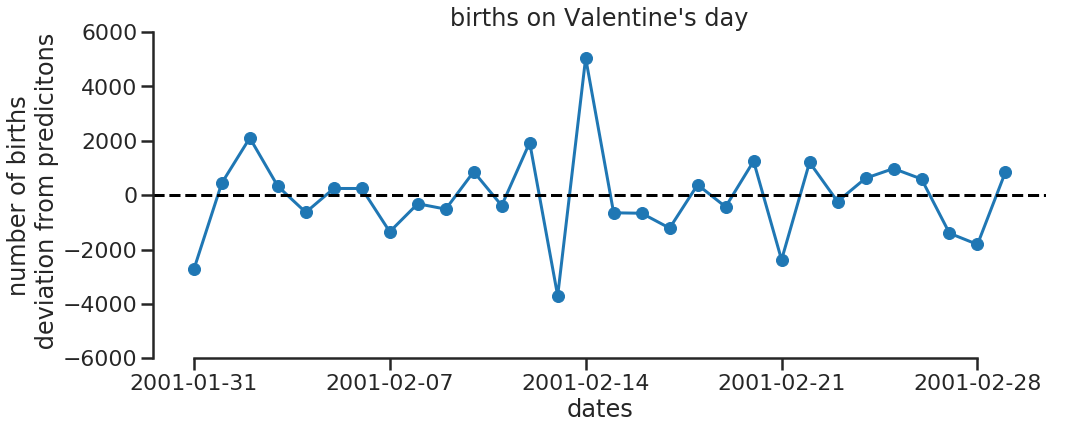

In [19]:
plt.figure(figsize=(16, 6))

plt.plot(
    result_decompose.resid.iloc[30:60], 
    '-o'
    )

plt.ylim(-6000,6000)
plt.axhline(0,linestyle='--',color='black')

plt.xlabel('dates')
plt.ylabel('number of births\n deviation from predicitons')
plt.title("births on Valentine's day")

sns.despine(trim=True)
plt.show()